# Simple GP Regression

The flow and some components of this notebook are inspired from [GPJAX regression notebook](https://gpjax.readthedocs.io/en/latest/examples/regression.html)

In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = ""

import jax
import jax.random as jr
import jax.numpy as jnp
import jax.tree_util as jtu

import tensorflow_probability.substrates.jax as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

import arviz as az

import matplotlib.pyplot as plt

import jaxopt

import gpax.kernels as gpk
import gpax.likelihoods as gpl
import gpax.means as gpm
from gpax.models import ExactGPRegression
from gpax.utils import index_pytree

jax.config.update("jax_enable_x64", True)

/home/patel_zeel/miniconda3/envs/jax_gpu/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: LOCAL is an invalid version and will not be supported in a future release
  warnings.warn(
/home/patel_zeel/miniconda3/envs/jax_gpu/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: pre-0.1 is an invalid version and will not be supported in a future release
  warnings.warn(


## Dataset

In [2]:
n = 100
noise = 0.3

key = jr.PRNGKey(123)
x = jr.uniform(key=key, minval=-3.0, maxval=3.0, shape=(n,)).sort().reshape(-1, 1)
f = lambda x: (jnp.sin(4 * x) + jnp.cos(2 * x)).flatten()
signal = f(x)
y = signal + jr.normal(key, shape=signal.shape) * noise

xtest = jnp.linspace(-3.5, 3.5, 500).reshape(-1, 1)
ytest = f(xtest)

print(x.shape, y.shape, xtest.shape, ytest.shape)

2023-02-03 20:58:18.613670: E external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


(100, 1) (100,) (500, 1) (500,)


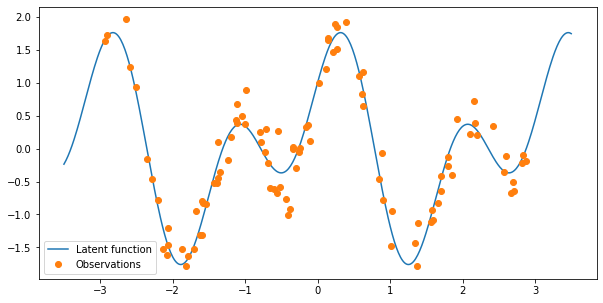

In [3]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(xtest, ytest, label="Latent function")
ax.plot(x, y, "o", label="Observations")
ax.legend(loc="best");

## Defining the kernel

In [4]:
base_kernel = gpk.RBF(x, lengthscale=0.5)  # x is used to infer the input dimension
# OR
# base_kernel = gpk.RBF(x)

kernel = gpk.Scale(x, base_kernel, variance=1.0)
# OR
# kernel = gpk.Scale(x, base_kernel)

print(kernel)

Scale(RBF)


In [5]:
kernel.get_parameters()

{'base_kernel': {'lengthscale': DeviceArray([0.5], dtype=float64, weak_type=True)},
 'variance': DeviceArray(1., dtype=float64, weak_type=True)}

In [6]:
kernel.initialize(key)  # random initialization
kernel.get_parameters()

{'base_kernel': {'lengthscale': DeviceArray([0.55735674], dtype=float64)},
 'variance': DeviceArray(1.349939, dtype=float64)}

In [7]:
kernel_fn = kernel.get_kernel_fn()
K, log_prob = kernel_fn(x, x)
K.shape, log_prob

((100, 100), 0.0)

Log prob in the above cell is used for advanced uses of this library. For now, it is totally fine to ignore it and consider returning this as a design choice. In eval model, the log prob is not returned.

In [8]:
kernel.eval()
kernel_fn = kernel.get_kernel_fn()
K = kernel_fn(x, x)
K.shape

(100, 100)

## Defining the likelihood

In [9]:
likelihood = gpl.Gaussian(scale=1.0)
print(likelihood)

Gaussian


In [10]:
likelihood.get_parameters()

{'scale': DeviceArray(1., dtype=float64, weak_type=True)}

In [11]:
likelihood.initialize(key)  # random initialization
likelihood.get_parameters()

{'scale': DeviceArray(1.349939, dtype=float64)}

## Defining the Mean Function

In [12]:
mean = gpm.Average()  # take the average of the observations as the mean
print(mean)

Average


In [13]:
mean.get_parameters()

{}

## Defining the model

In [14]:
model = ExactGPRegression(kernel, likelihood, mean)

In [15]:
model.get_parameters()

{'kernel': {'base_kernel': {'lengthscale': DeviceArray([0.55735674], dtype=float64)},
  'variance': DeviceArray(1.349939, dtype=float64)},
 'likelihood': {'scale': DeviceArray(1.349939, dtype=float64)},
 'mean': {}}

In [16]:
model.initialize(key)  # random initialization
model.get_parameters()

{'kernel': {'base_kernel': {'lengthscale': DeviceArray([0.62734237], dtype=float64)},
  'variance': DeviceArray(0.55735674, dtype=float64)},
 'likelihood': {'scale': DeviceArray(0.39294468, dtype=float64)},
 'mean': {}}

In [17]:
model.log_probability(x, y)

DeviceArray(-66.73193055, dtype=float64)

## Optimize the hyperparameters

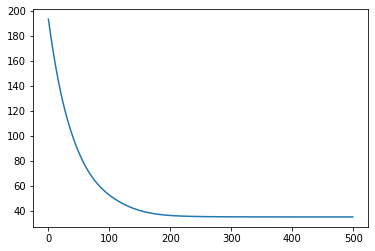

In [18]:
key = jr.PRNGKey(2)
lr = 0.01
epochs = 500

result = model.fit(key, x, y, lr=lr, epochs=epochs)  # default optimizer is Adam

plt.plot(result["loss_history"]);

In [19]:
print(model.log_probability(x, y))
model.get_parameters()

-34.985722644634365


{'kernel': {'base_kernel': {'lengthscale': DeviceArray([0.45091071], dtype=float64)},
  'variance': DeviceArray(1.41713267, dtype=float64)},
 'likelihood': {'scale': DeviceArray(0.25039347, dtype=float64)},
 'mean': {}}

## Plot Predictions

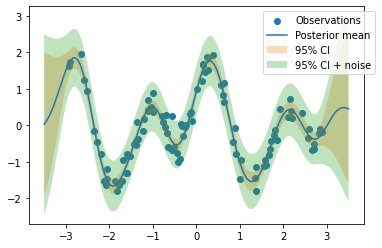

In [20]:
model.plot(x, y, xtest);

## Run multiple restarts

In [21]:
def single_run(key):
    model.initialize(key)
    return model.fit(key, x, y, lr=lr, epochs=epochs)

keys = jr.split(key, 10)
results = jax.vmap(single_run)(keys)

-34.985524393958784


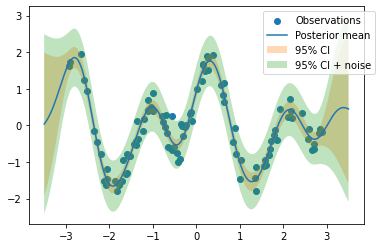

In [22]:
best_loss_idx = jnp.nanargmin(results["loss_history"][:, -1])  # nanargmin ignores NaNs 
best_result = index_pytree(results, best_loss_idx)  # get the best result
model.set_raw_parameters(best_result["raw_params"])
print(model.log_probability(x, y))
model.plot(x, y, xtest);

## Use second order optimization

-34.98552439395887


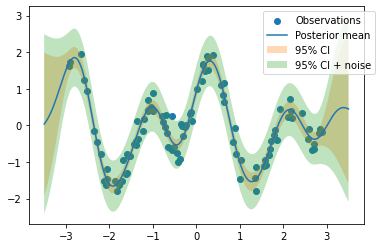

In [23]:
def loss_fn(raw_params, x, y):
    model.set_raw_parameters(raw_params)
    return -model.log_probability(x, y)

key = jr.PRNGKey(6)
raw_params = model.initialize(key).get_raw_parameters()

solver = jaxopt.ScipyMinimize(fun=loss_fn)
solution = solver.run(raw_params, x=x, y=y)

model.set_raw_parameters(solution.params)
print(model.log_probability(x, y))
model.plot(x, y, xtest);